# Un modo diverso di visualizzare l'audio
Fino ad adesso abbiamo mostrato gli audio appartenenti al nostro dataset senza nessun pre processamento importante. In questo notebook andremo a calcolare i filter banks degli audio, che ci permettono di visualizzare gli audio in un modo diverso e più espresisvo. I filter banks risultano molto utili quando si tratta l'argomento di speech recognition e speaker recognition, perciò capiremo anche quali sono i vantaggi di questa implementazione.

Prima di tutto importiamo le librerie e funzioni necessarie a mostrare e ascoltare un audio d'esempio. Questo codice è ormai familiare, essendo stato utilizzato nei notebook precedenti.

In [1]:
import wave
import numpy as np
import tensorflow as tf
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Audio, display

In [2]:
# prendiamo lo stesso audio utilizzato nei notebook precedenti
path_audio = '../reduced_dataset/dataset/audio/wow/0bde966a_nohash_1.wav'
sample_rate, samples = wavfile.read(path_audio) # legge il file audio

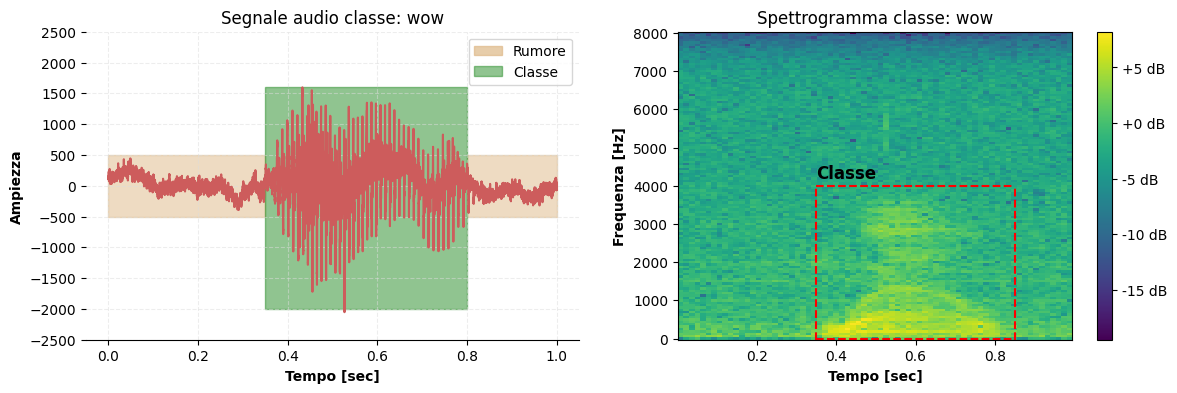

In [3]:
# raw wav
temporal_val = np.arange(len(samples)) / float(sample_rate)
audio = wave.open(path_audio, "r").readframes(-1)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area rumore
rumore_1 = mpatches.Rectangle((0, -500), width=0.35, height=1000, color='burlywood', alpha=0.5)
rumore_2 = mpatches.Rectangle((0.80, -500), width=0.20, height=1000, color='burlywood', alpha=0.5)
ax[0].add_patch(rumore_1)
ax[0].add_patch(rumore_2)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen", alpha=0.5)
ax[0].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", alpha=0.5, label="Classe")
rumore_handle = mpatches.Patch(color="burlywood", alpha=0.7, label="Rumore")
ax[0].legend(handles=[rumore_handle, classe_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# spettrogramma
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate) # creare lo spettrogramma

pcm1 = ax[1].pcolormesh(times, frequencies, np.log(spectrogram))
ax[1].set_ylabel('Frequenza [Hz]', fontweight="semibold") 
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
fig.colorbar(pcm1, ax=ax[1], format='%+2.0f dB')
ax[1].set_title("Spettrogramma classe: " + path_audio.split("/")[-2])

# ricognizione parola
ax[1].axhline(y=0, xmax=0.85, xmin=0.35, c='red', linestyle='--')
ax[1].axhline(y=4000, xmax=0.85, xmin=0.35, c='red', linestyle='--')
ax[1].axvline(x=0.35, ymax=0.50, ymin=0, c='red', linestyle='--')
ax[1].axvline(x=0.85, ymax=0.50, ymin=0, c='red', linestyle='--')
ax[1].text(0.35, 4200, "Classe", fontsize=12, fontweight="semibold")

plt.show()

Questi due grafici, rispettivamente le onde dell'audio e uno spettrogramma, non mostrano quello che noi realmente sentiamo. Tramite i filter banks saremo in grado di mostrare quello che l'orecchio umano percepisce.

Adesso ascoltiamo l'audio:

In [4]:
display(Audio(samples, rate=sample_rate, autoplay=False))

Questo audio non suona molto naturale, il che è dovuto al `sample_rate` (frequenza di campionamento campionamento) degli audio che stiamo trattando. In questo caso, l'audio è **campionato** a una **frequenza di 16kHz**, mentre siamo abituati ad ascoltare audio con frequenze di campionamento molto più alte. Ad esempio, la musica che ascoltiamo su YouTube o Spotify è solitamente campionata a 44.1kHz, ovvero 2.75 volte tanto.

Nonostante ciò, siamo comunque in grado di ascoltare l'audio campionato a 16kHz e, se necessario, potremmo ridurre ulteriormente la frequenza di campionamento a 8kHz per diminuire la dimensione del dataset e rimuovere alcune informazioni non essenziali.

L'audio presenta un leggero rumore, ma la parola "wow" è chiaramente udibile. Nel prossimo passaggio, ridurremo il rumore per rendere la parola ancora più chiara.

## I filter banks
I filter banks sono ideati per mimare la percezione umana dell'audio. Sono utilizzati per scomporre il segnale audio in diverse bande di frequenza, permettendo un'analisi dettagliata delle caratteristiche del segnale.

Per implementare i filter banks e condurre un'analisi corretta e approfondita del segnali audio, ci siamo ispirati ai seguenti articoli:
- [Speech Processing for Machine Learning](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html), che tratta i Filter Banks sia dal punto di vista teorico che pratico
- [Guide to Mel Frequency Cepstral Coefficient (MFCC)](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/), per comprendere il funzionamento teorico dei Filter Banks

Questi articoli ci hanno fornito le basi teoriche e pratiche necessarie per la nostra analisi.

Abbiamo strutturato il processo di generazione dei filter banks in XXX fasi:
- fase di pre-enfasi
- fase di framing
- fase di Hamming

### Fase di pre-enfasi

La pre-enfasi conserva maggiormente l'ampiezza delle frequenze dell'audio più alte, migliorando il rapporto segnale-rumore. Un miglior rapporto segnale-rumore riduce l'effetto del rumore di fondo, migliorando l'accuratezza delle analisi successive.

Utilizzeremo un coefficiente standard di `pre-enfasi` pari a `0.97`, che consente una maggiore amplificazione delle alte frequenze rispetto a coefficienti più bassi.

I principali scopi del filtro di `pre-enfasi` sono:
- bilanciare lo spettro delle alte frequenze
- evitare problemi numerici durante la trasformazione di Fourier
- migliorare il rapporto segnale-rumore (SNR, Signal-to-Noise Ratio)

L'equazione utilizzata per applicare la pre-enfasi a un segnale audio $x$ è la seguente:
$$
y(t)=x(t)−αx(t−1)
$$

Dove:
- $y(t)$ è il segnale audio pre-enfatizzato al time step $t$
- $x(t)$ è il segnale audio originale al time step $t$
- $α$ è il coefficiente di pre-enfasi che controlla l'attenuazione delle base frequenze rispetto alle alte frequenze
- $x(t−1)$ è il valore del segnale audio originale al time step $t-1$, ossia il campione precedente 

In questo caso $α$ determina quanto le frequenze alte vengono amplificate rispetto alle frequenze basse.

Applichiamo l'equazione e mostriamo i grafici precedenti con l'audio pre-enfatizzato.

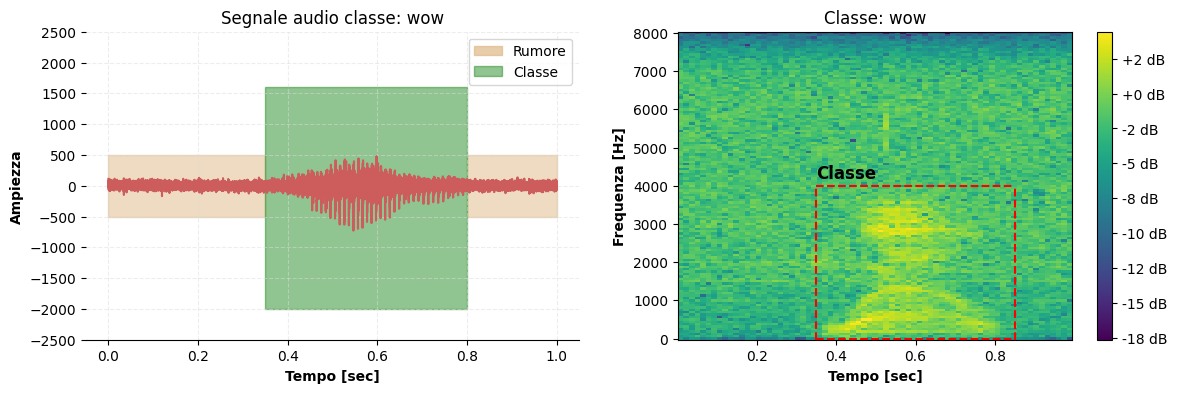

In [5]:
pre_emphasis = 0.97
emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(temporal_val, emphasized_signal, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area rumore
rumore_1 = mpatches.Rectangle((0, -500), width=0.35, height=1000, color='burlywood', alpha=0.5)
rumore_2 = mpatches.Rectangle((0.80, -500), width=0.20, height=1000, color='burlywood', alpha=0.5)
ax[0].add_patch(rumore_1)
ax[0].add_patch(rumore_2)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen", alpha=0.5)
ax[0].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", alpha=0.5, label="Classe")
rumore_handle = mpatches.Patch(color="burlywood", alpha=0.7, label="Rumore")
ax[0].legend(handles=[rumore_handle, classe_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# spettrogramma
frequencies, times, spectrogram = signal.spectrogram(emphasized_signal, sample_rate) # creare lo spettrogramma

pcm1 = ax[1].pcolormesh(times, frequencies, np.log(spectrogram))
ax[1].set_ylabel('Frequenza [Hz]', fontweight="semibold") 
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
fig.colorbar(pcm1, ax=ax[1], format='%+2.0f dB')
ax[1].set_title("Classe: " + path_audio.split("/")[-2])

# ricognizione parola
ax[1].axhline(y=0, xmax=0.85, xmin=0.35, c='red', linestyle='--')
ax[1].axhline(y=4000, xmax=0.85, xmin=0.35, c='red', linestyle='--')
ax[1].axvline(x=0.35, ymax=0.50, ymin=0, c='red', linestyle='--')
ax[1].axvline(x=0.85, ymax=0.50, ymin=0, c='red', linestyle='--')
ax[1].text(0.35, 4200, "Classe", fontsize=12, fontweight="semibold")

plt.show()

Notiamo un notevole cambiamento in entrambi i grafici. L'onda audio è ora più stabile, specialmente nella parte precedentemente rumorosa, dove le variazioni brusche sono state ridotte. 

Lo spettrogramma invece mostra un aumento della presenza delle frequenze alte. Questo è evidenziato dal colore giallo più intenso soprattutto nelle frequenze comprese tra 1000 e 4000 Hz.

Sentiamo l'audio:

In [6]:
display(Audio(emphasized_signal, rate=sample_rate, autoplay=False))

Anche l'audio è cambiato, il rumore è leggermente diminuito e la parola si sente più chiaramente.

### Fase di framing
Dopo aver completato la fase di pre-enfasi, procediamo con la fase di framing. Durante questa fase l'audio viene diviso in brevi segmenti a causa delle rapide variazioni delle frequenze nel tempo. Questa suddivisione è fondamentale per catturare le variazioni delle frequenze nel tempo, e permette un'analisi dettagliata delle caratteristiche spettrali del segnale audio.

In sostanza, lo **scopo alla base** di questa fase è acquisire in breve tempo e singolarmente ogni lettera pronunciata, o più precisamente la sua componente fonetica. Per chiarire questo concetto possiamo provare a visualizzarlo.

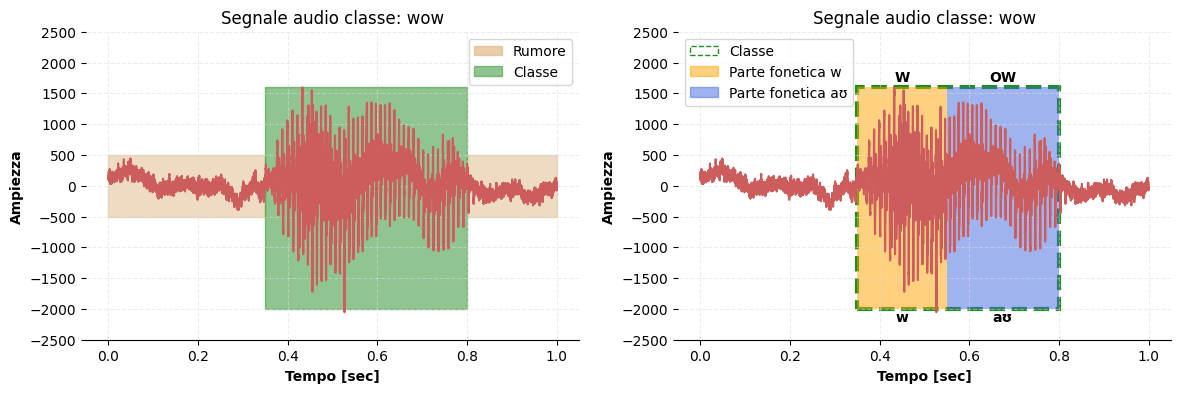

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# audio normale
ax[0].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area rumore
rumore_1 = mpatches.Rectangle((0, -500), width=0.35, height=1000, color='burlywood', alpha=0.5)
rumore_2 = mpatches.Rectangle((0.80, -500), width=0.20, height=1000, color='burlywood', alpha=0.5)
ax[0].add_patch(rumore_1)
ax[0].add_patch(rumore_2)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen", alpha=0.5)
ax[0].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", alpha=0.5, label="Classe")
rumore_handle = mpatches.Patch(color="burlywood", alpha=0.7, label="Rumore")
ax[0].legend(handles=[rumore_handle, classe_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# audio suddiviso in parti fonetiche
ax[1].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[1].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[1].add_patch(classe)
# area fonetica
fon_w = mpatches.Rectangle((0.35, -2000), width=0.20, height=3600, color="orange", alpha=0.5, linewidth=0)
fon_au = mpatches.Rectangle((0.55, -2000), width=0.25, height=3600, color="royalblue", alpha=0.5, linewidth=0)
ax[1].add_patch(fon_w)
ax[1].add_patch(fon_au)
# testi
# parola
ax[1].text((0.35 + 0.55)/2, 1700, "W", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[1].text((0.55 + 0.8)/2, 1700, "OW", fontsize=10, fontweight="semibold", horizontalalignment="center")
# fonetica
ax[1].text((0.35 + 0.55)/2, -2200, "w", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[1].text((0.55 + 0.8)/2, -2200, "aʊ", fontsize=10, fontweight="semibold", horizontalalignment="center")
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
fon_w_handle = mpatches.Patch(color="orange", label="Parte fonetica w", alpha=0.5)
fon_au_handle = mpatches.Patch(color="royalblue", label="Parte fonetica aʊ", alpha=0.5)
ax[1].legend(handles=[classe_handle, fon_w_handle, fon_au_handle])
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

Sulla sinistra è visibile l'audio originale, con una porzione evidenziata manualmente in verde (la nostra classe/parola). Sulla destra, invece, l'audio è stato suddiviso in due parti fonetiche. Il principio fondamentale della fase di framing consiste nell'abilità di estrarre informazioni rilevanti utilizzando segmenti di segnale sufficientemente piccoli da contenere una singola parte fonetica.

È importante notare che il risultato ottenuto non sarà identico all'immagine mostrata sulla destra, poiché i segmenti saranno notevolmente più piccoli e numerosi.

Nella maggior parte dei casi, eseguire la **trasformata di Fourier** sull'intero sengale audio non è ottimale poiché le frequenze possono variare rapidamente nel tempo. È preferibile considerare brevi periodi di tempo come stazionari e applicare la trasformata di Fourier su di essi. Questo fornisce una buona approssimazione delle frequenze nel fotogramma temporale considerato.

Per la segmentazione del nostro segnale audio, adottiamo gli standard tipici solitamente impiegati per il processamento del linguaggio:
- `frame_size` di 25ms, indica la durata di ciascun frame
- `frame_stride` di 10ms, indica l'intervallo di tempo tra l'inizio di un frame e l'inizio del successivo

Ad esempio, con `frame_size` di **25ms** e `frame_stride` di **10ms**, ogni nuovo frame inizia 10ms dopo l'inizio del precedente, creando un overlap di **15ms** tra i frame adiacenti.

In [8]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convertiamo da secondi a samples
signal_length = len(emphasized_signal)

# Per rendere il calcolo più agevole le due variabili vengono convertite e arrotondate in numeri interi
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  #Il numero di frame viene calcolato come il rapporto tra la lunghezza effettiva del segnale e il singolo step
#in questo modo siamo sicuri che ci sia almeno un frame anche se il segnale è più corto di frame_length

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal serve per essere sicuri che tutti i samples abbiano la stessa lunghezza

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

Una volta calcolati i frame, possiamo visualizzare ciò che abbiamo approssimativamente ottenuto.

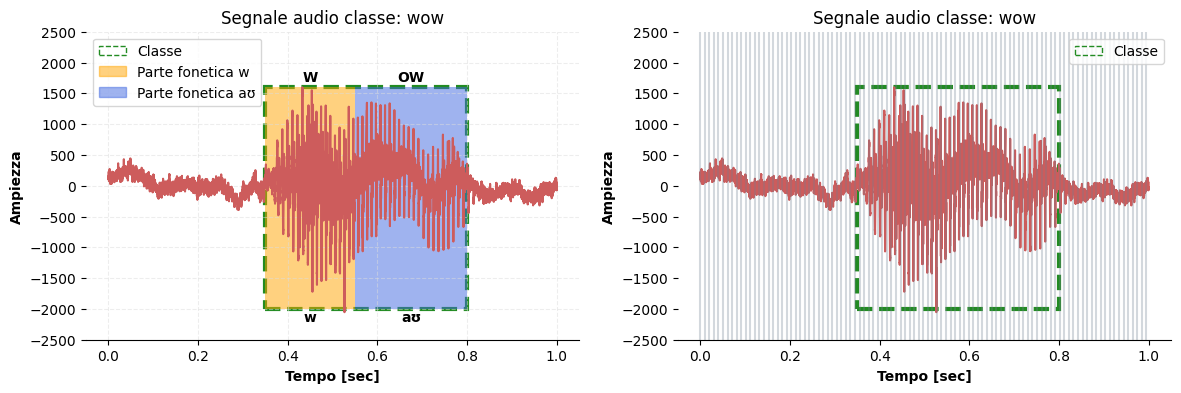

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# audio suddiviso in parti fonetiche
ax[0].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[0].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
ax[0].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[0].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[0].add_patch(classe)
# area fonetica
fon_w = mpatches.Rectangle((0.35, -2000), width=0.20, height=3600, color="orange", alpha=0.5, linewidth=0)
fon_au = mpatches.Rectangle((0.55, -2000), width=0.25, height=3600, color="royalblue", alpha=0.5, linewidth=0)
ax[0].add_patch(fon_w)
ax[0].add_patch(fon_au)
# testi
# parola
ax[0].text((0.35 + 0.55)/2, 1700, "W", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[0].text((0.55 + 0.8)/2, 1700, "OW", fontsize=10, fontweight="semibold", horizontalalignment="center")
# fonetica
ax[0].text((0.35 + 0.55)/2, -2200, "w", fontsize=10, fontweight="semibold", horizontalalignment="center")
ax[0].text((0.55 + 0.8)/2, -2200, "aʊ", fontsize=10, fontweight="semibold", horizontalalignment="center")
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
fon_w_handle = mpatches.Patch(color="orange", label="Parte fonetica w", alpha=0.5)
fon_au_handle = mpatches.Patch(color="royalblue", label="Parte fonetica aʊ", alpha=0.5)
ax[0].legend(handles=[classe_handle, fon_w_handle, fon_au_handle])
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)


# audio suddiviso in parti fonetiche
ax[1].plot(temporal_val, samples, label='nohash_1.wav', color="indianred")
# forzo la l'asse y
ax[1].set_yticks(range(-2500, 3000, 500))
# label e titolo
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
ax[1].set_xlabel('Tempo [sec]', fontweight="semibold")
ax[1].set_title("Segnale audio classe: " + path_audio.split("/")[-2])
# nascondo bordi plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# area parola
classe = mpatches.Rectangle((0.35, -2000), width=0.45, height=3600, color="forestgreen",fill=None, linestyle="--", linewidth=3)
ax[1].add_patch(classe)
#legenda
classe_handle = mpatches.Patch(color="forestgreen", label="Classe", fill=None, linestyle="--")
ax[1].legend(handles=[classe_handle])
# grid
# linee frame
for i in range(num_frames + 1):
    ax[1].axvline(i * 0.01015, alpha=0.3, color="slategrey")

plt.show()


Il grafico a destra illustra la suddivisione dell'audio in segmenti. È importante sottolineare che questa rappresentazione è approssimativa e non deve essere considerata precisa, ma piuttosto come un mezzo per comprendere il processo eseguito e il suo scopo.

Mostriamo alcuni segmenti:

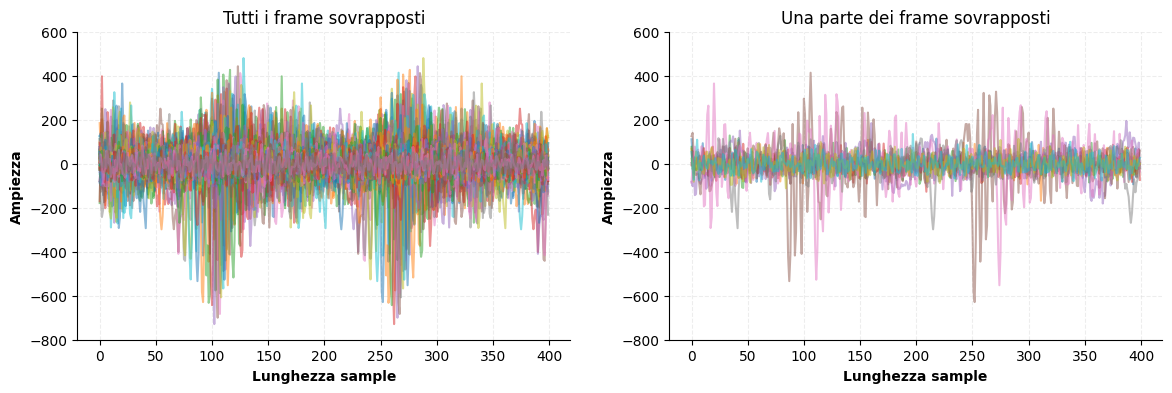

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

for i in range(0, num_frames):
    ax[0].plot(frames[i], alpha=0.5)  # Usa alpha per la trasparenza

ax[0].set_yticks(range(-800, 800, 200))
ax[0].set_title('Tutti i frame sovrapposti')
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo bordi plot
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# parte dei frame sovrapposti
for i in range(0, num_frames, 10):
    ax[1].plot(frames[i], alpha=0.5)  # Usa alpha per la trasparenza

ax[1].set_yticks(range(-800, 800, 200))
ax[1].set_title('Una parte dei frame sovrapposti')
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo bordi plot
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

Nei due grafici rappresentati, da sinistra verso destra, abbiamo rispettivamente tutti i frame sovrapposti e soltanto una selezione (ogni 10) dei frame sovrapposti. È evidente la presenza di numerosi segmenti con ampiezze principalmente basse, i quali potrebbero essere scartati poiché privi di informazioni significative.

È chiaro come risulti più agevole estrarre informazioni rilevanti dopo aver completato la fase di framing.

**Effettivamente ci serve mostrare questo grafico? Parlarne con Andrea, Theo, Giovi, e il professore.**

### Fase di Hamming

Dopo aver suddiviso i segnali audio in segmenti, è necessario applicare una **funzione finestra**, che ci permette di ridurre la dispersione spettrale. 

Una funzione finestra è una funzione (o forma) che è diversa da zero per un determinato intervallo di tempo, mentre è zero prima o dopo tale intervallo. Questa funzione finestra viene moltiplicata per un segnale, producendo un'uscita pari a zero eccettto durante l'intervallo in cui la finestra è diversa da zero, permettendo di esporre il segnale solo in quel periodo.

Un esempio semplice di finestra è una finestra rettangolare, che è pari a zero, poi brevemente a uno, e quindi ritorna a zero. Il segnale ottenuto dopo l'applicazione della finestra sarà udibile solo durante l'intervallo in cui viene moltiplicato per uno, cioè durante il periodo in cui la finestra rettangolare è attiva.

Esistono diversi tipi di forme di una finestra, e noi utilizzeremo nello specifico la dinestra di Hamming, definita dalla seguente espressione:
$$
w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right)
$$
per $0 ≤ n ≤ N - 1$, dove $N$ è la lunghezza della finestra.

Definiamo noi stessi la funzione di Hamming invece di utilizzare quella di numpy:

In [11]:
# Implementiamo la funzione di Hamming
def makeHamming(M):
    R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
    w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
    if M % 2 != 0:
        w[0] = w[0]/2
        w[M-1] = w[M-1]/2
    else:
        w = w[:M]
        
    return w

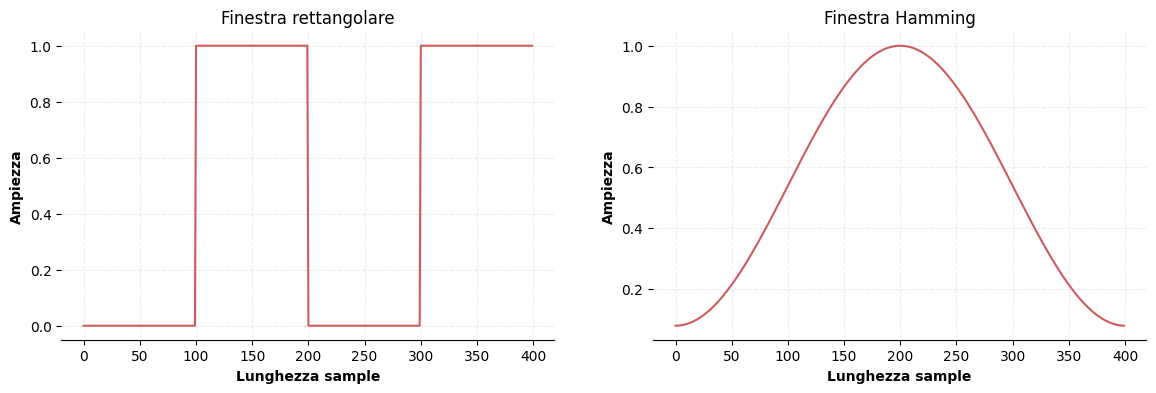

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

rectangular_window = (np.concatenate((np.zeros(frame_length // 4),
                                      np.ones(frame_length // 4),
                                     np.zeros(frame_length // 4),
                                     np.ones(frame_length // 4))))
hamming_window = makeHamming(frame_length)

# window function rettangolare
ax[0].plot(rectangular_window, c="indianred")
# titolo e label
ax[0].set_title("Finestra rettangolare")
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# window function hamming
ax[1].plot(hamming_window, c="indianred")
# titolo e label
ax[1].set_title("Finestra Hamming")
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

La finestra rettangolare ha un comportamento "on/off", dove il segnale è completamente presente durante l'intervallo attivo e assente al di fuori di esso. La fine di Hamming invece fornisce un graduale smorzamento ai bordi, riducendo gli artefatti e la dispersione spettrale nel segnale.

In [13]:
frames_rect_window = frames * rectangular_window
frames_hamming_window = frames * hamming_window

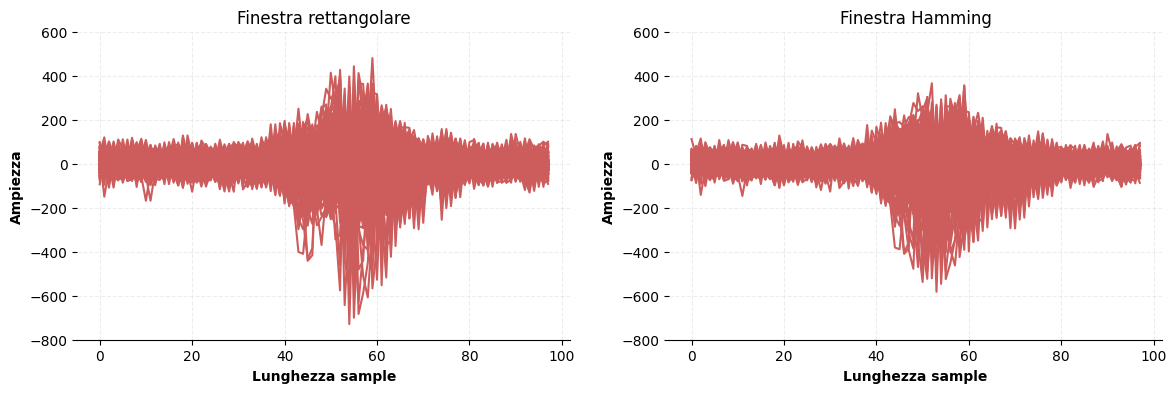

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# window function rettangolare
ax[0].plot(frames_rect_window, c="indianred")
# titolo e label
ax[0].set_title("Finestra rettangolare")
ax[0].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[0].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[0].spines["left"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
# y ticks
ax[0].set_yticks(range(-800, 800, 200))
# grid
ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

# window function hamming
ax[1].plot(frames_hamming_window, c="indianred")
# titolo e label
ax[1].set_title("Finestra Hamming")
ax[1].set_xlabel('Lunghezza sample', fontweight="semibold")
ax[1].set_ylabel('Ampiezza', fontweight="semibold")
# nascondo i bordi del plot
ax[1].spines["left"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# y ticks
ax[1].set_yticks(range(-800, 800, 200))
# grid
ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)

plt.show()

Come evidenziato nel grafico, l'applicazione della finestra di Hamming restringe i valori del segnale all'intervallo $[0, N-1]$, mentre l'applicazione della finestra rettangolare da noi creata produce una limitazione dei valori in modo diverso.

È da notare che la finestra di Hamming si dimostra superiore in quanto contribuisce a una miglior rappresentazione spettrale del segnale audio, riducendo le perdite di  causate dalle discontinuità.

### Trasformata di Fourier
Per ottenere un risultato ottimale nel processamento dei segnali audio, è una buona pratica applicare la Trasformata di Fourier. Questa trasformata viene applicata a ogni segmento audio per calcolare lo spettro delle frequenze, scomponendo il segnale audio in una somma di sinusoidi e velocizzando il calcolo.

La Trasformata di Fourier permette di identificare le principali frequenze presenti in un segnale audio. Questa particolare trasformata è chiamata `N-point FFT` (Fast Fourier Transform), dove $N$ è tipicamente una potenza di $2$, come $256$ o $512$. Nel nostro caso, abbiamo scelto di utilizzare `N = 512`. Possiamo quindi calcolare l'ampiezza della FFT e salvare il suo valore nella variabile `mag_frames`.

Con l'ausilio della Trasformata di Fourier, possiamo calcolare lo spettro delle potenze del segnale audio, utilizzando la seguente equazione:
$$
P = \frac{| \text{FFT}(x_i) |^2}{N}
$$

dove $x_i$ è l' $i$-esimo frame del segnale audio $x$.

In [20]:
NFFT = 512 # oppure 256
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Spettro delle potenze

## Filter Banks

A questo punto, possiamo finalmente creare i Filter Banks, che si ottengono applicando dei filtri triangolari. Tipicamente il numero dei filtri che vengono utilizzati è 40, per questo motivo anche noi abbiamo deciso di utilizzare tale standard.
I filtri saranno applicati su una scala particolare chiamata Scala Mel.
La Scala Mel viene impiegata per convertire le Frequenze (f), in Mel (m), con l'obiettivo di discriminare le basse frequenze e di essere meno discriminante verso le alte frequenze, in quanto sappiamo che l'orecchio umano è per natura, agevolato a percepire meglio le basse frequenze.

Per convertire le Frequenze in Mel e/o viceversa si applicano le seguenti equazioni:

$$\ m = 2595 \log_{10} \left(1 + \frac{f}{700}\right)$$

$$\ f = 700 \left(\frac{10m}{2595} - 1\right)$$

Ogni Filter Bank ha una forma triangolare che diventa pari ad 1 al centro della frequenza e decresce fino a raggiungere lo 0 al centro dei due filtri che sono adiacenti.

MEL min: 0
MEL max: 2840.023046708319


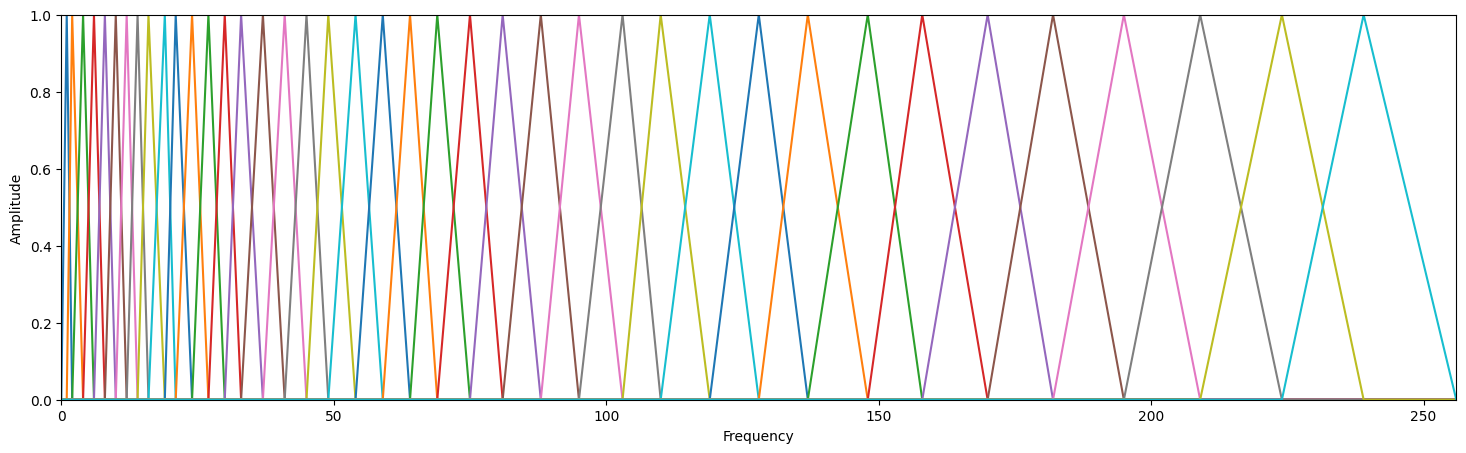

In [37]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convertiamo Hz in Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

print("MEL min: {0}".format(low_freq_mel))
print("MEL max: {0}".format(high_freq_mel))

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

plt.figure(figsize=(18,5))
for n in range(fbank.shape[0]):
    plt.plot(fbank[n])
    plt.margins(x=0)
    plt.margins(y=0)
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency')

È possibile ora avere una visione completa dei Filter Banks, questi saranno poi applicati allo spettrogramma dell'audio preso come campione ad inizio Notebook.
Sarà interessante poi, vedere le differenze tra le prestazioni di un modello convolutivo che riceve in input i singoli spettrogrammi con e senza Filter Banks

A questo punto possiamo generare un plot che contiene un'immagine con uno spettrogramma a cui sono stati applicati i Filter Banks.
Come possiamo notare le alte frequenze, in rosso, hanno un forte impatto a livello visivo e questo si suppone che porterà un ipotetico modello convolutivo ad effettuare delle computazioni diverse e con conseguenze che potrebbero essere positive oppure negative.

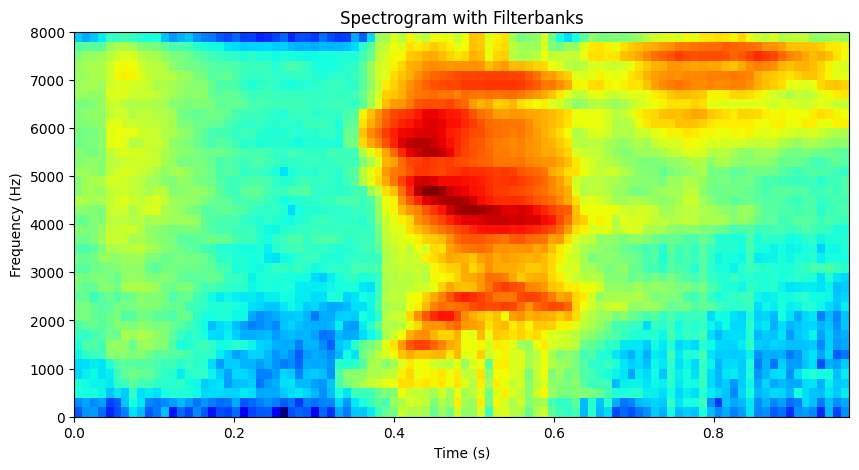

In [40]:
time_frames = np.arange(0, num_frames) * frame_stride
plt.figure(figsize=(10, 5))

plt.imshow(filter_banks.T, origin='lower', aspect='auto', cmap='jet', extent=[time_frames[0], time_frames[-1], hz_points[0], hz_points[-1]])

plt.title('Spectrogram with Filterbanks')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

Qualora fosse necessario, è possibile normalizzare i Filter Banks, per migliorare la qualità delle Frequenze e di conseguenza ottenere uno spettrogramma che risulti più pulito e che dia ulteriore importanza alle alte frequenze.

In [82]:
#filter banks normalizzati
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8) #normalizzazione con la media
normalized_filter_banks = filter_banks

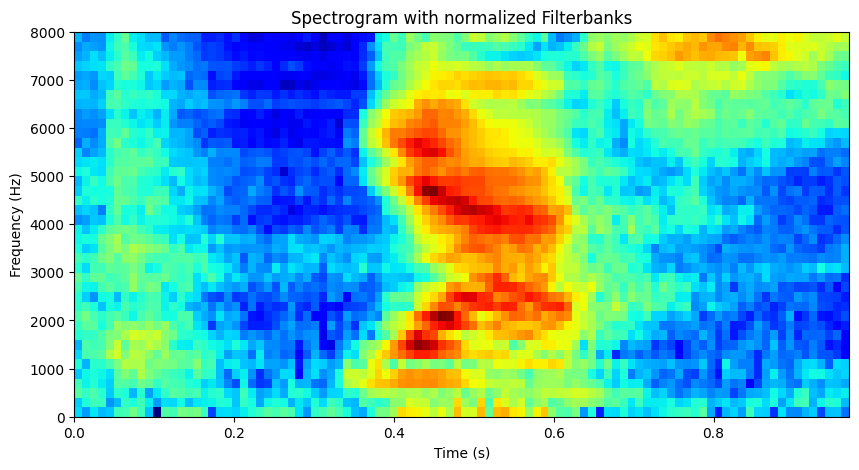

In [87]:
time_frames = np.arange(0, num_frames) * frame_stride
plt.figure(figsize=(10, 5))

plt.imshow(normalized_filter_banks.T, origin='lower', aspect='auto', cmap='jet', extent=[time_frames[0], time_frames[-1], hz_points[0], hz_points[-1]])

plt.title('Spectrogram with normalized Filterbanks')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

## Mel-Frequency Cepstarl Coefficients (MFCCs)

Risulta che i Filter Banks precedentemente calcolati siano altamente correlati, questo potrebbe risultare problemtico per alcuni versi. Per decorrelare i Filter Banks, possiamo applicare la Trasformata del Coseno Discreto (DCT).Generalmente, viene utilizzato un numero di coefficienti Cep (Cepstral Coefficients) compreso tra 2 e 13.
Nel nostro caso, seguendo l'articolo da cui abbiamo preso ispirazione posiamo `num_ceps = 12`.

In [41]:
num_ceps = 12 #numero di Cepstral Coefficients
cep_lifter = 22
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] #calcoliamo i Mel-Frequency Cepstral Coefficients

(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

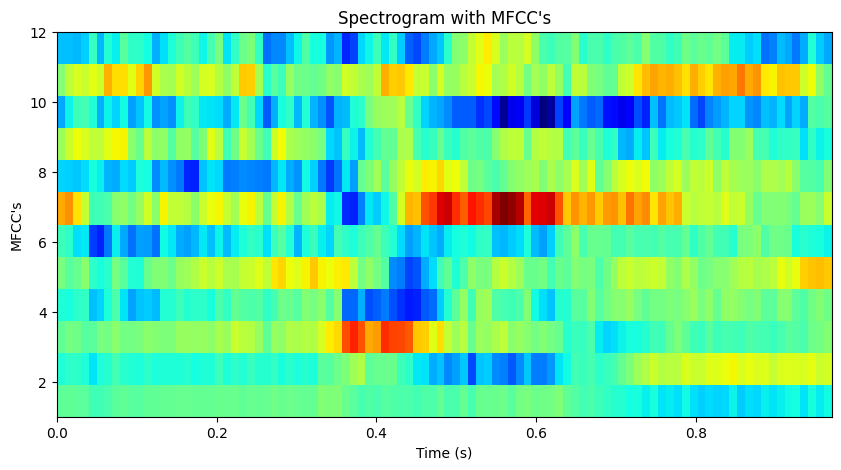

In [42]:
time_frames = np.arange(0, num_frames) * frame_stride
extent = [time_frames[0], time_frames[-1], 1, num_ceps]

plt.figure(figsize=(10, 5))
plt.imshow(mfcc.T, origin='lower', aspect='auto', cmap='jet', extent = extent)
plt.title('Spectrogram with MFCC\'s')
plt.ylabel('MFCC\'s')
plt.xlabel('Time (s)')
plt.show()

Anche con i MFCCs, qualora fosse necessario, è possibile applicare una normalizzazione basata sulla media, per migliorare la qualità delle Frequenze e di conseguenza ottenere uno spettrogramma che risulti più pulito e che dia ulteriore importanza alle alte frequenze.

In [86]:
#MFCC normalizzati
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
normalized_mfcc = mfcc

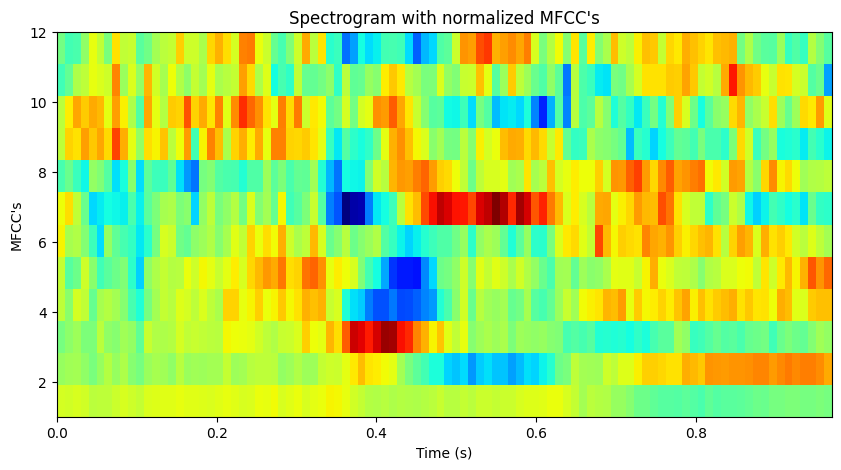

In [88]:
time_frames = np.arange(0, num_frames) * frame_stride
extent = [time_frames[0], time_frames[-1], 1, num_ceps]

plt.figure(figsize=(10, 5))
plt.imshow(normalized_mfcc.T, origin='lower', aspect='auto', cmap='jet', extent = extent)
plt.title('Spectrogram with normalized MFCC\'s')
plt.ylabel('MFCC\'s')
plt.xlabel('Time (s)')
plt.show()

## Conclusioni

Dopo un'attenta analisi tra Filter Banks e MFFCs, possiamo confrontarli e cercare di capire per quali motivi potremmo impiegare gli uni piuttosto che gli altri.
Il principale obiettivo dei Filter Banks è quello di "valorizzare" le alte frequenze, che sono maggiormente difficili da percepire rispetto alle basse frequenze. Per quanto riguarda i MFCCs, invece, sono principalmente utilizzati per motivi di natura computazionale, infatti potrebbe verificarsi una situazione in cui i Filter Banks, non sono adatti all'analisi delle frequenze audio, a questo proposito viene applicata una Trasformata Discreta del Coseno, ottenendo una decorrelazione dei Filter Banks per una maggiore chiarezza.


In [ ]:
# CAMBIARE COME VIENE CITATO, NON ESEGUIRE (LO FARO' PRIMA O POI, LASCIATE QUI COSI' MI RICORDO - Gabry)
@misc{fayek2016,
  title   = "Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between",
  author  = "Haytham M. Fayek",
  year    = "2016",
  url     = "https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html"
}